In [90]:
import itertools
import pathlib

import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0,
    "transparent": True,
}
output_dir = "../../figures/figureS3"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg", ".eps"]
sc.settings.figdir = output_dir
sc.set_figure_params(format="svg", transparent=True)
sc.settings.figdir = output_dir
sc.set_figure_params(format="svg", transparent=True)
sc.set_figure_params(dpi_save=300)


def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None


sns.set_context("paper")
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
plt.style.use("../../scripts/paper.mplstyle")
width = plt.rcParams["figure.figsize"][0]
height = plt.rcParams["figure.figsize"][1]
%run ../../scripts/btreceptor_draw.py
%run ../../scripts/btreceptor_sequences.py
%run ../../scripts/plotting_helper.py

<Figure size 180x180 with 0 Axes>

In [2]:
adata = sc.read_h5ad("../../processed_data/h5ad_objects/bcells.h5ad")
ird = adata.obs
adata = adata_add_lineages_from_IR(adata, similarity_cutoff = 0.95)

In [3]:
ftc = ird[ird.sample_id.str.contains("Day")]

In [4]:
print(ftc.shape[0], "cells in the in vitro time course")
tc = ftc[~ftc.sample_id.str.contains("Day 0")]
print(tc.shape[0], "cells in the Days 4, 8, 12")
clones = selection_helper(ftc, "clone_id", 1)
print(clones.shape[0], "cells with a related member in dataset")

27358 cells in the in vitro time course
11477 cells in the Days 4, 8, 12
5373 cells with a related member in dataset


In [44]:
adata.obs.clone_id.value_counts()

22547    68
18120    27
22644    17
23799    15
22616    14
         ..
10176     1
10175     1
10174     1
10173     1
30247     1
Name: clone_id, Length: 30248, dtype: int64

I have reason to believe clone 22547 is an artefact of ambient RNA so I'm going to remove it

In [48]:
adata = adata[adata.obs.clone_id != '22547']

# General class Switching Picture

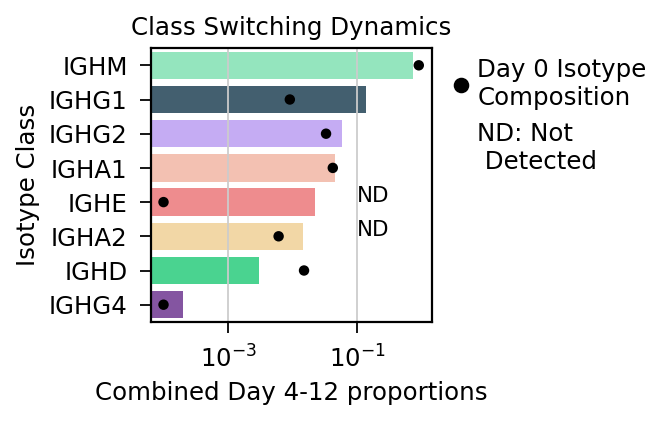

In [49]:
order = IGH_order
ird = adata.obs
# analyze just timecourse
ird.dropna(subset=["IR_VDJ_1_c_call"], inplace=True)
ird = ird[ird.IR_VDJ_1_c_call.str.contains("IGH")]
ird = selection_helper(ird, "clone_id", 1)
# Day+
tc = ird[ird.sample_id.str.contains("Day")]
tc = tc[~tc.sample_id.str.contains("Day 0")]
tc = tc.IR_VDJ_1_c_call.value_counts(normalize=True)
tc = pd.DataFrame(tc)
tc = tc.reset_index()
order = tc.sort_values(by="IR_VDJ_1_c_call", ascending=False)["index"]
palette = igh_colors
# Day+
dz = ird[ird.sample_id.str.contains("Day 0")]
dz = dz.IR_VDJ_1_c_call.value_counts(normalize=True)
dz = pd.DataFrame(dz)
dz = dz.reset_index()
# add a pseudo-count for Day zero not detected isotypes
dz['pseudocount_isotype'] = dz['IR_VDJ_1_c_call'] + 0.0001
fig, ax = plt.subplots(1, 1)
sns.barplot(
    data=tc, y="index", x="IR_VDJ_1_c_call", order=order, palette=palette, alpha=0.8
)
sns.pointplot(
    data=dz, y="index", x="pseudocount_isotype", order=order, color="k", join=False
)
plt.xlabel("Combined Day 4-12 proportions")
plt.ylabel("Isotype Class")
plt.xscale("log")
plt.title("Class Switching Dynamics")

# create legend
legend_elements = [
    Line2D([0],[0],
        color="k", marker='o',
    markersize=3, linewidth=0,
        label="Day 0 Isotype\nComposition",
    ), 
mpl.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0, label = 'ND: Not\n Detected')]
# annotate the not detected isotypes as such
ax.annotate("ND", (0.1, 4)) # IGHG3
ax.annotate("ND", (0.1, 5)) # IGHE
ax.annotate("ND", (0.01, 8)) # IGHG4

ax.legend(
    handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0
)

In [50]:
save_figure(fig, "combined_differentiation_day0_isotype_composition")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


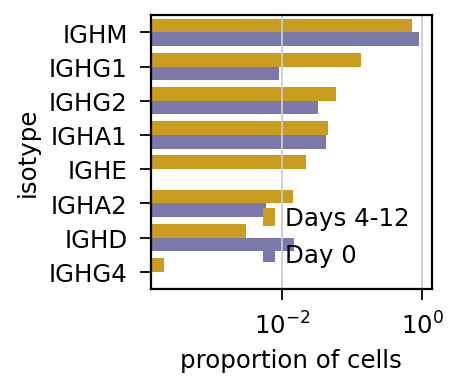

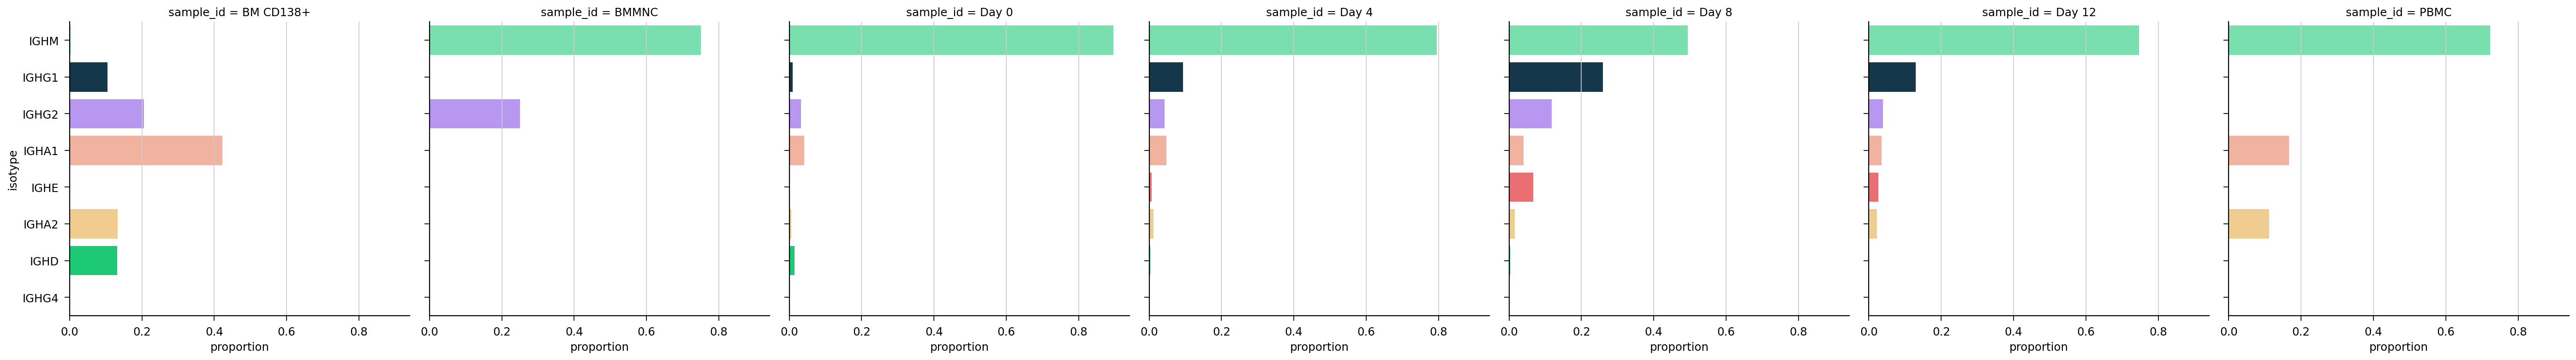

In [51]:
dz["Input"] = "Day 0"
tc["Input"] = "Days 4-12"

df = pd.concat([tc, dz])

fig, ax = plt.subplots(1, 1)
sns.barplot(
    data=df, y="index", x="IR_VDJ_1_c_call", order=order, hue="Input", palette="Dark2_r"
)
plt.legend(loc="lower right")
plt.ylabel("isotype")
plt.xlabel("proportion of cells")
plt.xscale("log")

save_figure(fig, "switching_dynamics_bar_2_timepoints")

data = (
    ird.groupby("sample_id").IR_VDJ_1_c_call.value_counts(normalize=True).reset_index()
)

data.columns = ["sample_id", "isotype", "proportion"]

g = sns.catplot(
    data=data,
    x="proportion",
    y="isotype",
    col="sample_id",
    order=order,
    kind="bar",
    palette=igh_colors,
)

fig = g.fig

save_figure(fig, "facet_isotype_proportions_all_timepoints")

In [56]:
ird = adata.obs

In [57]:
print(ird.groupby(['sample_id', 'bcelltype']).IR_VDJ_1_c_call.value_counts(normalize = True).xs('Day 8'))

bcelltype                
B cells             IGHM     0.797980
                    IGHG1    0.101010
                    IGHA1    0.040404
                    IGHE     0.025253
                    IGHG2    0.020202
                    IGHA2    0.015152
                    IGHD     0.000000
                    IGHG4    0.000000
Naive B cells       IGHM     0.400862
                    IGHG1    0.258621
                    IGHG2    0.176724
                    IGHE     0.163793
                    IGHA1    0.000000
                    IGHA2    0.000000
                    IGHD     0.000000
                    IGHG4    0.000000
Plasma cells        IGHM     0.386431
                    IGHG1    0.336283
                    IGHG2    0.123894
                    IGHA1    0.085546
                    IGHE     0.041298
                    IGHA2    0.026549
                    IGHD     0.000000
                    IGHG4    0.000000
Plasmablasts        IGHM     0.395604
                    IGHG

In [58]:
df = ird.groupby(['sample_id', 'bcelltype']).switched.value_counts(normalize = False)
df = df.reset_index()

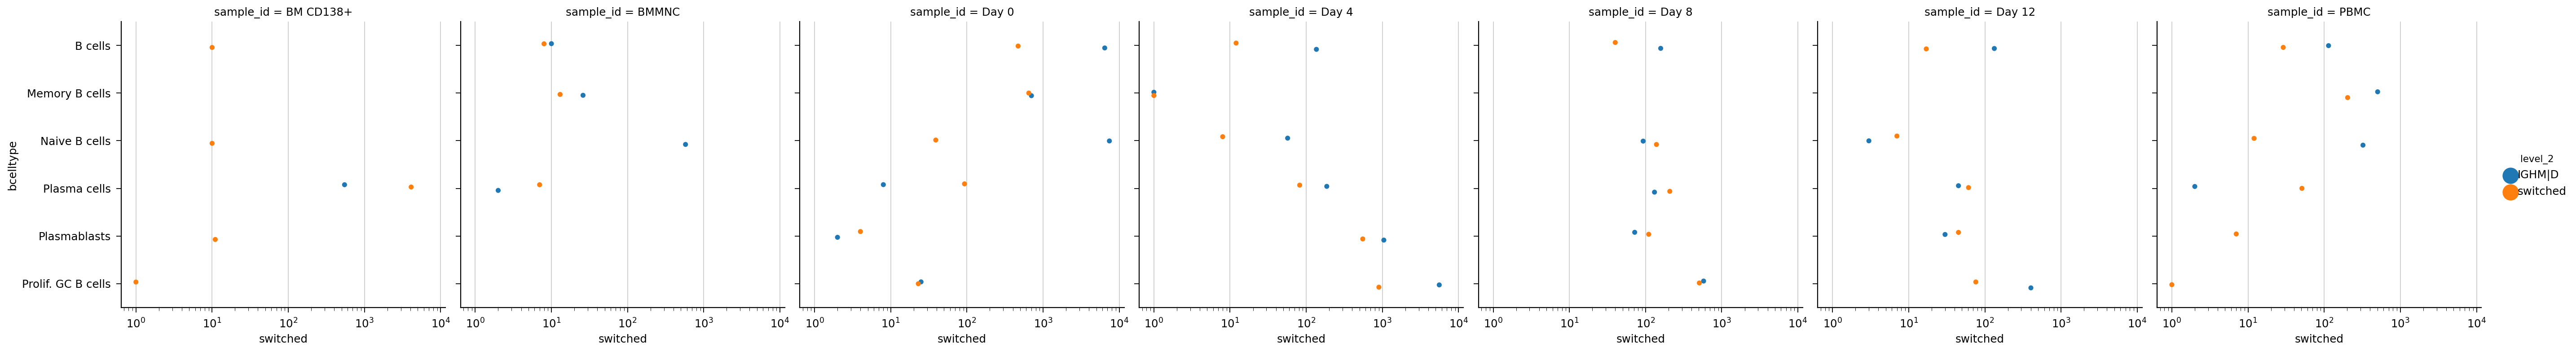

In [59]:
sns.catplot(data = df, x = 'switched', y = 'bcelltype', hue = 'level_2', col='sample_id')
plt.xscale('log')

In [60]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, receptor_arms="all", dual_ir="primary_only")

/home/michaelswift/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/30247 [00:00<?, ?it/s]

In [61]:
ir.tl.clonotype_network(adata, min_cells=3)



<AxesSubplot:>

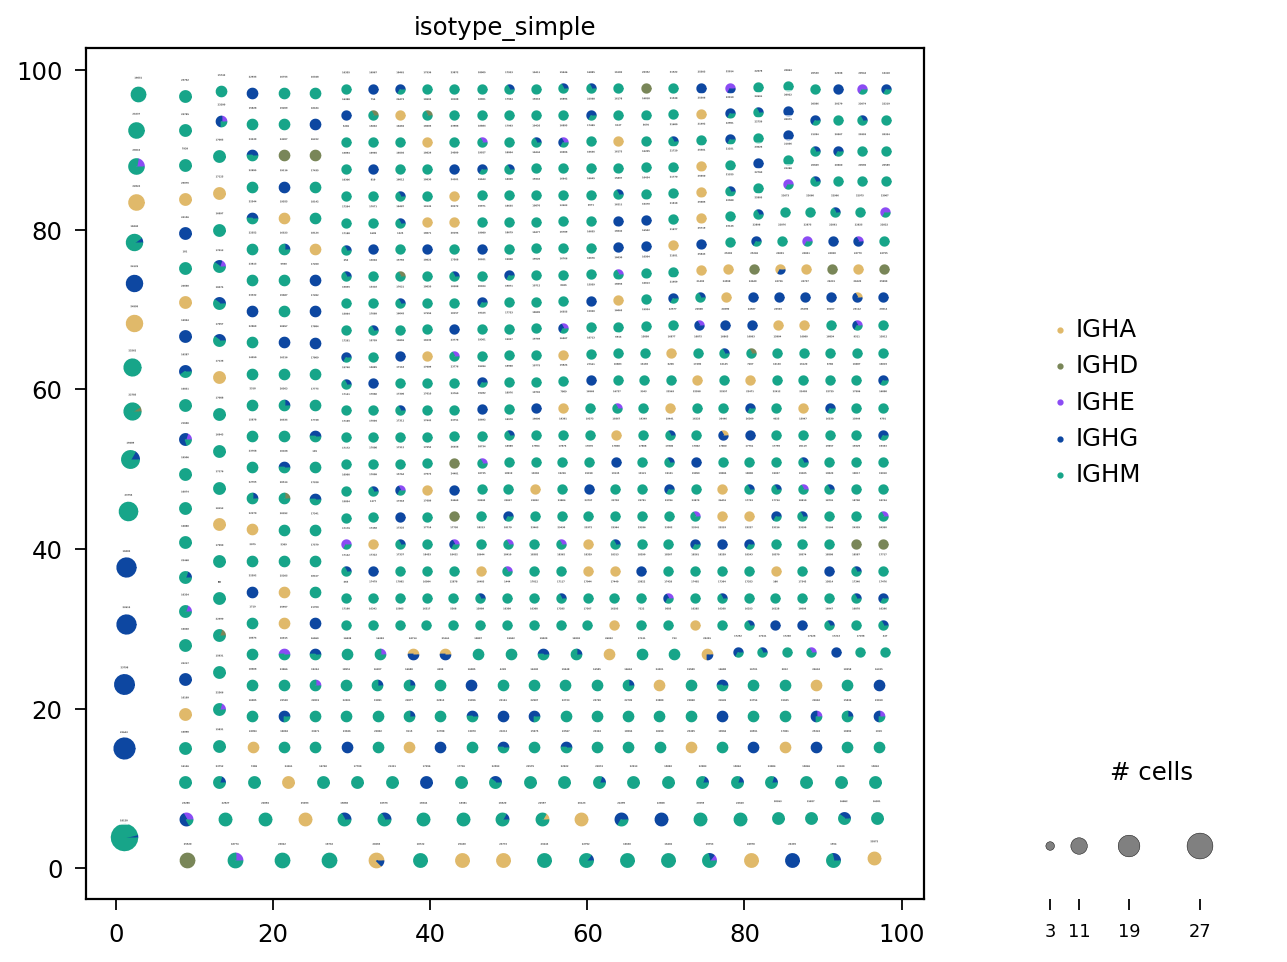

In [62]:
ir.pl.clonotype_network(
    adata, color="isotype_simple", base_size=5, label_fontsize=0, panel_size=(7, 7), palette=igh_colors_simple
)

In [88]:
sns.set_context("talk")

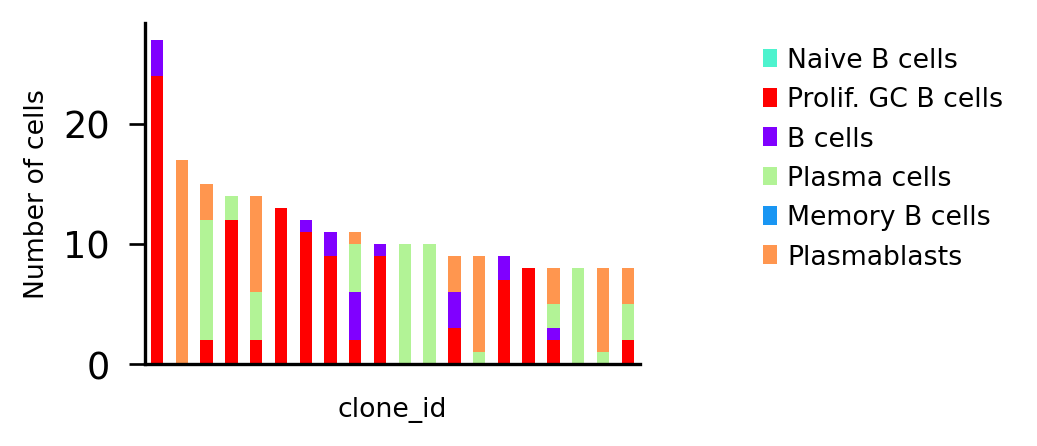

In [91]:
groupby = "clone_id"
target_col = "bcelltype"
ax = ir.pl.group_abundance(adata, groupby=groupby, target_col=target_col, max_cols=20, normalize = False)
ax.set_xticklabels([], rotation = 90)
ax.set_title(label = "")
save_figure(ax.figure, "{}_{}_countplot".format(groupby, target_col))

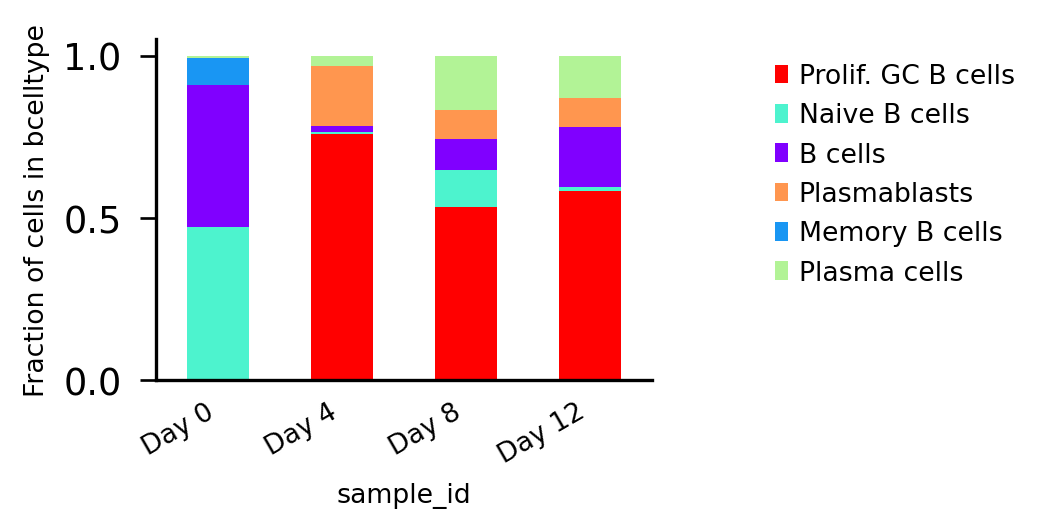

In [92]:
groupby = "sample_id"
target_col = "bcelltype"
ax = ir.pl.group_abundance(adata[adata.obs.sample_id.str.contains("Day")], groupby=groupby, target_col=target_col, max_cols=20, normalize = True)
ax.set_title(label = "")
save_figure(ax.figure, "{}_{}_countplot".format(groupby, target_col))

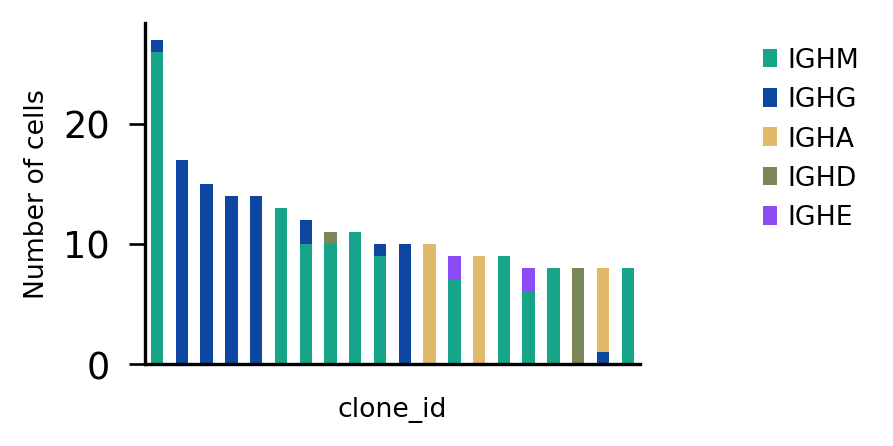

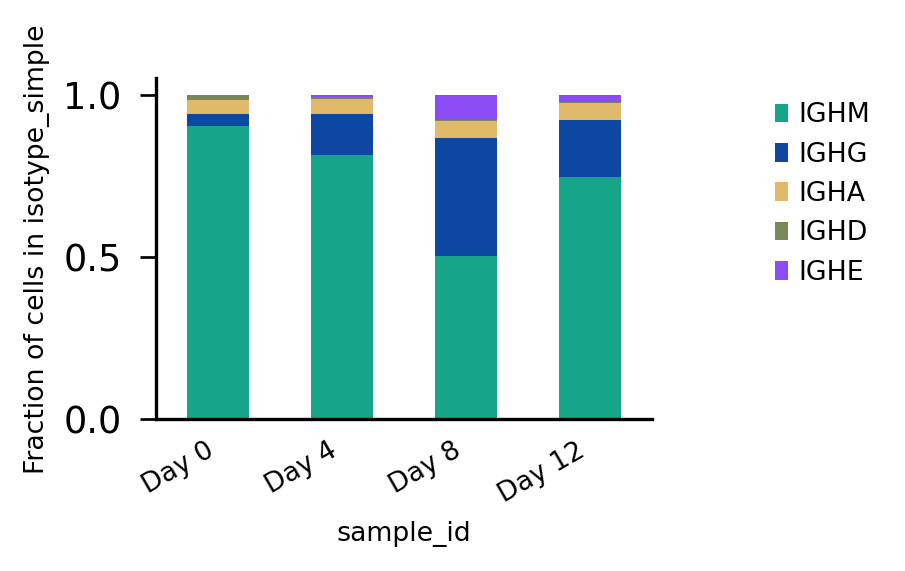

In [93]:
groupby = "clone_id"
target_col = "isotype_simple"
ax = ir.pl.group_abundance(adata, groupby=groupby, target_col=target_col, max_cols=20, normalize = False)
ax.set_xticklabels([], rotation = 90)
ax.set_title(label = "")
save_figure(ax.figure, "{}_{}_countplot".format(groupby, target_col))

groupby = "sample_id"
target_col = "isotype_simple"
ax = ir.pl.group_abundance(adata[adata.obs.sample_id.str.contains("Day")], groupby=groupby, target_col=target_col, max_cols=20, normalize = True)
ax.set_title(label = "")
save_figure(ax.figure, "{}_{}_countplot".format(groupby, target_col))

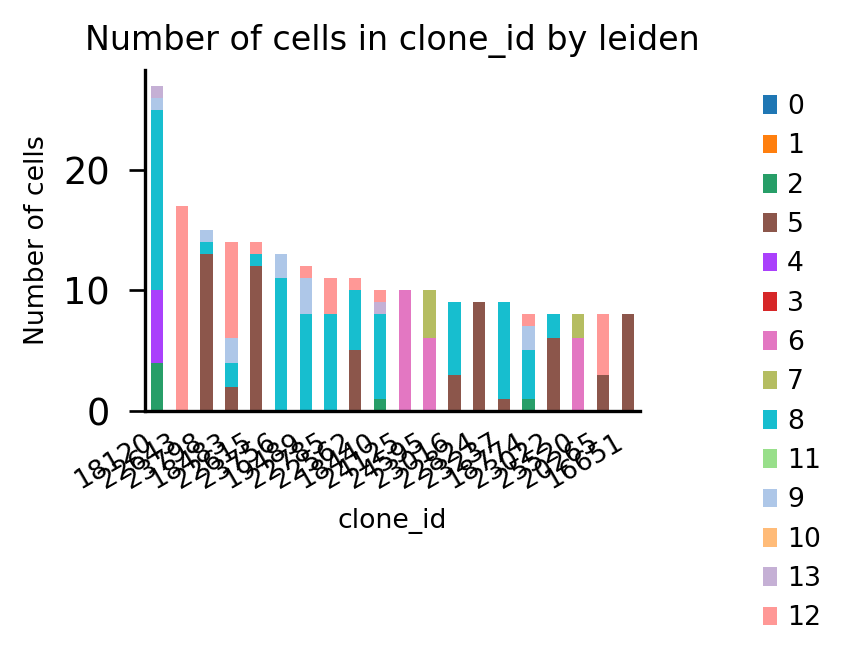

In [85]:
groupby = "clone_id"
target_col = "leiden"
ax = ir.pl.group_abundance(adata, groupby=groupby, target_col=target_col, max_cols=20)
save_figure(ax.figure, "{}_{}_countplot".format(groupby, target_col))